# EXERCISE 07 - The irreducible mass of black holes.

This is an example that comes straight out of my research in general relativity.

**Gerosa, Fabbri, Sperhake (2022) "The irreducible mass and the horizon area of LIGO's black holes"** [arxiv:2202.08848](https://arxiv.org/abs/2202.08848), [CQG 39 (2022) 175008](https://iopscience.iop.org/article/10.1088/1361-6382/ac8332)

(some of the calculations here were first worked out by Cecilia Fabbri in her BSc thesis with me).

Consider a rotating black hole. In 1969, Roger Penrose (now Nobel Prize in Physics for the theory of black holes) discovered that one can extract energy from a rotating black hole. Maybe some of you has seen this already in your GR class? In any case, a rotating black-hole has a region called ergosphere such that infalling particles have negative energy. Penrose imagined a particle that enters that region and decays: half will fall in and half will escape to infinity, carring some energy with it. In a nutshell, we've extracted energy=mass from a black hole! It turns out that one also has to extract angular momentum, not just energy (and here you'll need some GR do to this calculation, see e.g. the famous textbook by Misner, Thorne and Weeler). But angular momentum runs our first, such that a repeated series of Penrose processes leaves behind a non-rotating BH with a remnant mass which is called "irreducible". This is a famous result by Christodoulou 1970 and is closely related to the even more famous area law by Hawking (1971) (which in turns is the foundation of black-hole thermodynamics -- for you, my theorethical physics friend).

For a BH of mass $M$ spin $\chi \in [0, 1]$, the irreducible mass is

 $M_{irr} = M\sqrt{\frac{1 + \sqrt{1 - \chi^2}}{2}}$

For convenience, let us define

 $f(\chi) = \sqrt{\frac{1 + \sqrt{1 - \chi^2}}{2}}$

Suppose you have repeated measurments of $M$ and $\chi$. This is just because we're still frequentists for now. When we will put our Bayesian hat on, these distributions will be the posterior samples from a single measurement.

Let's assume that

- the spin $\chi$ is uniformly distributed between 0 and 1.
- the mass $M$ is normally distributed with mean $\mu$ and standard deviation $\sigma$.
- (masses and spins are uncorrelated)

These are simplistic assumption that, however, are not too far from what we are now measuring with gravitational-wave detectors. It's a toy model, but not a totally unreasonable one.

## IMPORT MODULES

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import astroML.stats as aMLstats

from astropy.visualization import hist

from scipy.stats import norm
from scipy.stats import uniform
from scipy.stats import ks_2samp

from sklearn.neighbors import KernelDensity

In [8]:
# USEFULL FUNCTIONS

def f(chi):
    return np.sqrt((1 + np.sqrt(1 - chi**2)) / 2)

def m_irr(M, chi):
    return M * f(chi)

def kde(data, bw, kernel, n=1000):
    kde_skl = KernelDensity(bandwidth=bw, kernel=kernel)
    kde_skl.fit(data[:, np.newaxis])
    x = np.linspace(data.min(), data.max(), n)
    log_pdf = kde_skl.score_samples(x[:, np.newaxis]) # sklearn returns log(density)
    return np.exp(log_pdf)

# L07:

## Tasks:

1. Start with a value of $\sigma = 0.02$. Note that $\mu$ is a scale and not a parameter: you can normalize all quantities with a dimension of mass by $\mu$. Just set $\mu = 1$ in your code and remember that all masses in the problem are measured in units of $\mu$.

2. Plot the resulting pdf of $M_{irr}$. First try an histogram with one the rules of thumb we've seen above.

*Hint* (for point 2): You don't know the functional form of the pdf of $M_{irr}$... but you don't need it if you just want to generate samples! That's the nice thing about numerics!

3. Using the same samples, plot the distribution of $M_{irr}$ using a KDE.

4. Compute the KS distance between $M_{irr} / M$ and $f$ as a function of $\sigma$. Discuss the limits at large and small values of $\sigma$.

5. Compute the KS distance between $M_{irr}$ and $M$ as a function of $\sigma$. Discuss the limits at large and small values of $\sigma$.

*Hint* (for points 4 and 5). This is a KS test between two sets for samples, `scipy.stats.ks_2samp`.

You should find that (i) $M_{irr}$ is distributed like $f$ if $\sigma \ll \mu$ and (ii) $M_{irr}$ is distributed like $M$ if $\sigma \gg \mu$.

# 1 - RULE OF THUMB

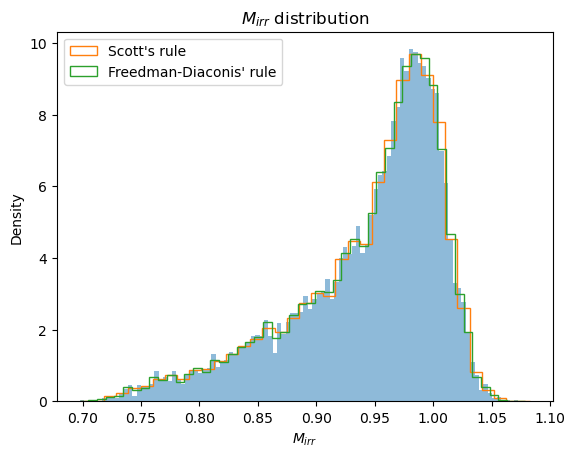

In [9]:
N = 10000

M, chi = norm.rvs(1, .02, N), uniform.rvs(0, 1, N)

M_irr = m_irr(M, chi)

plt.hist(M_irr, bins=100, density=True, alpha=.5, label='Data')
hist(M_irr, bins='scott', density=True, histtype='step', label="Scott's rule")
hist(M_irr, bins='freedman', density=True, histtype='step', label="Freedman-Diaconis' rule")

plt.title('$M_{irr}$ distribution')
plt.xlabel('$M_{irr}$')
plt.ylabel('Density')
plt.legend();

# 2 - KDE distribution

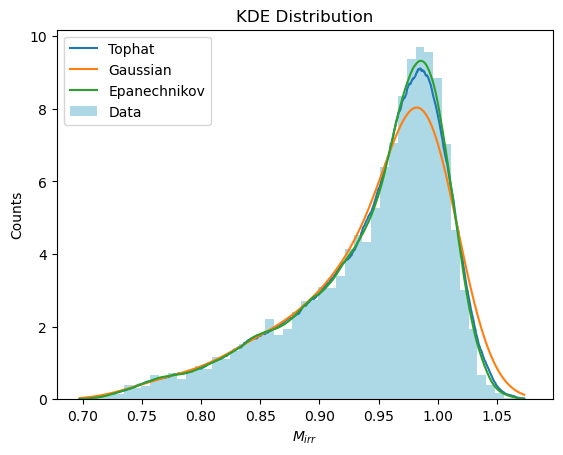

In [14]:
n = 1000
sigma = .02

PDF_TH = kde(M_irr, sigma, kernel="tophat", n=n) 
PDF_G = kde(M_irr, sigma, kernel="gaussian", n=n)
PDF_E = kde(M_irr, sigma, kernel="epanechnikov", n=n)

x = np.linspace(M_irr.min(), M_irr.max(), n)

hist(M_irr, bins="freedman", color ="lightblue", density=True, label = "Data")
plt.plot(x, PDF_TH, label="Tophat")
plt.plot(x, PDF_G, label="Gaussian")
plt.plot(x, PDF_E, label="Epanechnikov")


plt.title("KDE Distribution")
plt.xlabel("$M_{irr}$")
plt.ylabel("Density")
plt.legend();

# 3 - KS DISTANCE

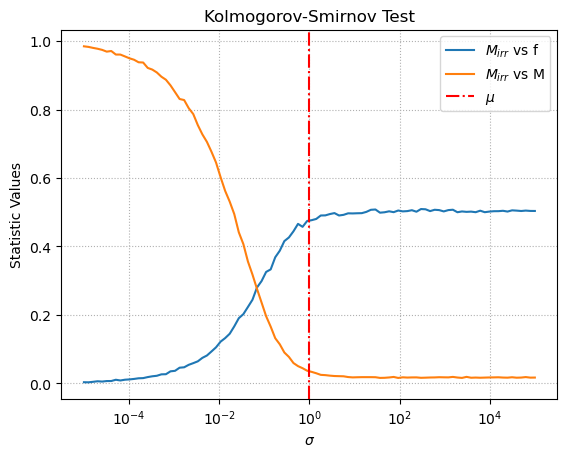

In [18]:
mu = 1

ks_f = []
ks_M = []
sigma_vec = np.logspace(-5, 5, 100)

for s in sigma_vec:
    M = norm.rvs(mu, s, N)
    chi = uniform.rvs(0, 1, N)

    ks_f_stat, _ = ks_2samp(f(chi), m_irr(M, chi))
    ks_M_stat, _ = ks_2samp(M, m_irr(M, chi))

    ks_f.append(ks_f_stat)
    ks_M.append(ks_M_stat)

plt.plot(sigma_vec, ks_f, label="$M_{irr}$ vs f")
plt.plot(sigma_vec, ks_M, label="$M_{irr}$ vs M")
plt.axvline(mu, linestyle = '-.', c = 'r', label = "$\mu$")
plt.semilogx()

plt.title("Kolmogorov-Smirnov Test")
plt.xlabel("$\sigma$")
plt.ylabel("Statistic Values")
plt.legend()
plt.grid(linestyle = ":");